# Summary:

#### 1. Data analysis and visualization
> 1. Checking for Nulls - No nulls in data
> 2. Taking log transformation for y (views for video)
> 3. Dropping outliers in y 
>> 2 datapoints dropped (3% data)
> 4. Visualization
>> - Distribution of videos across channels
>>> Similarly distributed
>> - Comparison of distribution of views for video across channels
>> - Correlation between length and views on video 
>>> - Slight upward trend
>> - Correlation between publish date and views on video
>>> No trend observed
>> - Correlation between various recipe features
>>> 4 recipe features dropped (correlation > 70%)
>> - Correlation between various genome features
>>> 4 genome features dropped (correlation > 70%)

#### 2. Data Preparation
> 1. Normalization of all numeric features
> 2. One-hot encoding for categorical features
> 3. Splitting data into train and test
>> Groups videos with same length and released on same day together in train or test.


#### 3. Data modelling
> 0. Baseline Model - Mean of y
> 1. Ridge Regression
> 2. MLP Regressor (neural network)
> 3. Gradient Booster Model
>> Performs best with a lift in MSE value of ~1.4 units in log transformation

#### 4. Model Analysis + post regression test
> 1. Visualizing predicted vs actual data
>> Predicted data has less spread and a higher peak near the mean value compared to true data. 
> 2. Feature importance
>> Length of video, channel_italian and genome_7 are the top 3 most important features
> 3. Post regression tests
>> Test confirm there is no concern with the assumptions or residuals:
>> - Multicollinearity
>> - Residual plot
>> - Normality of residuals


#### 5. Approach 2 - Using a 3 stage model - classification + regression + weighted sum
> Constructed ensemble model is not able to generate lower MSEs as compared to Gradient Booster model.

#### Future Work:
> - To build a better model, we need to collect more data specially for videos that get higher views
> - Another approach could be to group the data into bins with the binwidth (range of bin) increasing as the views increase
> > - For instance, bins in the lower range be 0-10, 10-20 .... while bins in the higher range be of the nature 20,000-30,000 , ..... , 100,000-150,000 and so on <br />
> > - Depending on the use case, it might be valuable to find which bin the video belongs to rather than knowing the exact number of views.

### Code:

In [1]:
import pandas as pd
import numpy as np
import math

import seaborn as sns
import matplotlib.pyplot as plt

import random
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics.cluster import normalized_mutual_info_score, fowlkes_mallows_score
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn import decomposition
from sklearn.linear_model import Ridge
from sklearn.neural_network import MLPRegressor
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor

from statsmodels.compat import lzip
import statsmodels.stats.api as sms

# Loading the data

In [2]:
# Loading the dataset
data = pd.read_csv('view_model_challenge.csv')

# Setting up an ID column for videos 
data['vid_id'] = [1000+x for x in data[data.columns[0]]] #making index column to start from 1000 to be sure the index is retained throughout
data.drop(columns = data.columns[0], axis = 1, inplace = True)

# Making the ID column the index for the dataframe
data.set_index('vid_id', inplace = True)

### Data Wrangling

In [3]:
data.head(4)

,channel_name,publish_date,length,recipe_0,recipe_1,recipe_2,recipe_3,recipe_4,recipe_5,recipe_6,...,genome_21,genome_22,genome_23,genome_24,genome_25,genome_26,genome_27,genome_28,genome_29,Views
vid_id,,,,,,,,,,,,,,,,,,,,,
1000,French,27.01.22,235,0.087378,0.266357,0.601746,0.038415,0.139688,0.874650,0.043642,...,0.000409,0.000011,0.000044,0.000409,0.000001,0.000002,0.002768,0.000001,0.000041,394
1001,French,19.01.22,345,0.188133,0.023232,0.436932,0.104682,0.242425,0.593734,0.025685,...,0.001240,0.000093,0.000027,0.000241,0.000063,0.000029,0.039632,0.000103,0.000137,259
1002,French,19.01.22,219,0.162995,0.021242,0.377679,0.132312,0.275497,0.453573,0.045817,...,0.000749,0.000659,0.000049,0.000031,0.000057,0.000034,0.001257,0.000152,0.000217,161
1003,French,19.01.22,422,0.230495,0.050815,0.431094,0.103429,0.212753,0.480772,0.026075,...,0.000057,0.000038,0.000013,0.000021,0.000416,0.000038,0.016069,0.000065,0.000048,282


In [4]:
# Inspecting at the size of the dataset
print("Shape of dataset: ", data.shape)

# Inspecting the columns of dataset
print("\nFollowing are the columns in dataset:\n", data.columns)

Shape of dataset:  (619, 46)

Following are the columns in dataset:
 Index(['channel_name', 'publish_date', 'length', 'recipe_0', 'recipe_1',
       'recipe_2', 'recipe_3', 'recipe_4', 'recipe_5', 'recipe_6', 'recipe_7',
       'recipe_8', 'recipe_9', 'recipe_10', 'recipe_11', 'genome_0',
       'genome_1', 'genome_2', 'genome_3', 'genome_4', 'genome_5', 'genome_6',
       'genome_7', 'genome_8', 'genome_9', 'genome_10', 'genome_11',
       'genome_12', 'genome_13', 'genome_14', 'genome_15', 'genome_16',
       'genome_17', 'genome_18', 'genome_19', 'genome_20', 'genome_21',
       'genome_22', 'genome_23', 'genome_24', 'genome_25', 'genome_26',
       'genome_27', 'genome_28', 'genome_29', 'Views'],
      dtype='object')


We have 45 features for the videos and a count of the views for the video

In [5]:
data.describe()

,length,recipe_0,recipe_1,recipe_2,recipe_3,recipe_4,recipe_5,recipe_6,recipe_7,recipe_8,...,genome_21,genome_22,genome_23,genome_24,genome_25,genome_26,genome_27,genome_28,genome_29,Views
count,619.000000,619.000000,619.000000,619.000000,619.000000,619.000000,619.000000,619.000000,619.000000,619.000000,...,6.190000e+02,6.190000e+02,6.190000e+02,6.190000e+02,6.190000e+02,6.190000e+02,6.190000e+02,6.190000e+02,619.000000,6.190000e+02
mean,177.156704,0.115894,0.084858,0.319286,0.092681,0.370560,0.545560,0.067142,0.252181,0.202256,...,3.730201e-02,5.515860e-03,3.993702e-03,3.255531e-03,3.584673e-02,5.359682e-03,4.038045e-03,6.662851e-03,0.004035,5.947660e+04
std,188.069617,0.087407,0.117376,0.135470,0.093290,0.180450,0.176769,0.079947,0.095575,0.118811,...,1.507676e-01,2.202111e-02,1.246768e-02,1.147026e-02,1.611971e-01,5.122840e-02,1.809855e-02,3.200931e-02,0.015324,5.510964e+05
min,11.000000,0.007529,0.000751,0.020824,0.008419,0.069147,0.179662,0.001882,0.006929,0.000129,...,3.960000e-07,1.750000e-07,4.200000e-07,9.640000e-08,2.470000e-07,1.450000e-07,5.360000e-07,7.370000e-08,0.000002,3.600000e+01
25%,40.000000,0.052502,0.016262,0.213416,0.034077,0.234225,0.429386,0.023087,0.193139,0.099874,...,3.780000e-05,2.725000e-05,3.965000e-05,2.520000e-05,5.725000e-05,5.010000e-05,8.145000e-05,2.280000e-05,0.000128,5.805000e+02
50%,100.000000,0.093971,0.035709,0.299654,0.061470,0.327311,0.505706,0.039475,0.263162,0.201993,...,2.085650e-04,1.789130e-04,3.914560e-04,1.730320e-04,2.803330e-04,2.604590e-04,2.928740e-04,1.092120e-04,0.000528,3.000000e+03
75%,229.000000,0.151352,0.092115,0.411964,0.106502,0.500424,0.647023,0.081071,0.320122,0.286485,...,1.416188e-03,1.770399e-03,1.702385e-03,1.169335e-03,1.348534e-03,1.112694e-03,9.822890e-04,5.335660e-04,0.001736,1.577800e+04
max,792.000000,0.578307,0.694463,0.748063,0.590172,0.840794,0.992934,0.563923,0.519213,0.609592,...,9.573568e-01,2.948446e-01,1.577794e-01,1.352400e-01,9.831529e-01,7.510337e-01,2.214017e-01,3.811688e-01,0.213694,1.294378e+07


#### Setting publish date to yyyy.mm.dd format
This will ensure date is read correctly and also give accurate estimates when asked for a summarization (min/max)

In [6]:
data['publish_date'] = [('20'+x[6:]+'.'+x[3:5]+'.'+x[0:2]) for x in data['publish_date']]
print("Data spans from %s to %s"%(data['publish_date'].min(), data['publish_date'].max()))

Data spans from 2011.06.19 to 2022.01.31


# Data Analysis & Visualization

#### Checking for Nulls

In [7]:
data.isna().sum().any()

False

Fortunately our data has no Null values.

In case of Null values with a short amount of data such as ~600 records, we cannot drop the Null records but would need to impute the Null values using mean or median.

#### Let us look at the distribution for the metric we wish to predict - the views for a video

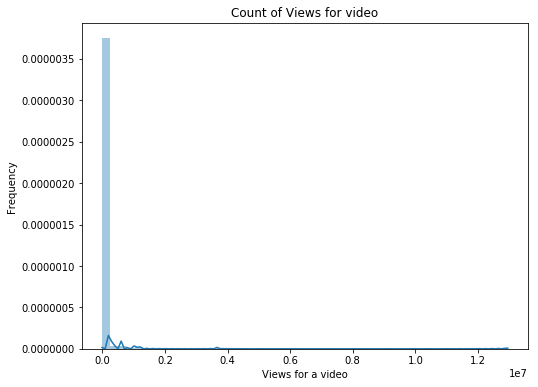

In [8]:
plt.figure(figsize = (8,6))
ax = sns.distplot(data['Views'])
ax.set(xlabel='Views for a video', 
       ylabel='Frequency', 
       title = 'Count of Views for video')
plt.show()

The data is heavily skewed to the right. Some videos have very high number of views. It might be better to use some tranformation for the metric.
### Using transformations for y: 
Let us visualize using log and squareroot

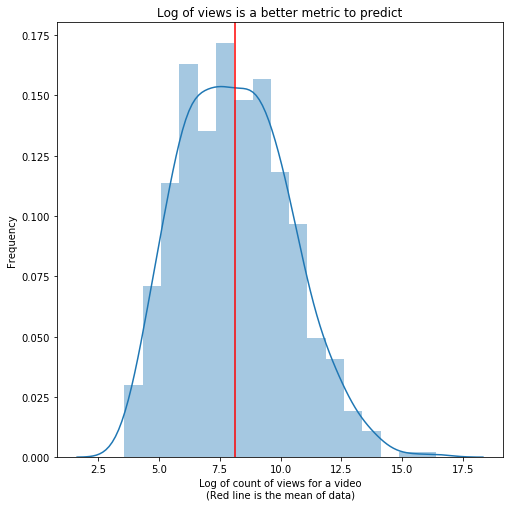

In [9]:
plt.figure(figsize = (8,8))
ax = sns.distplot(np.log(data['Views']))
plt.axvline(x=np.log(data['Views']).mean(), color='red')
ax.set(xlabel='Log of count of views for a video\n(Red line is the mean of data)', 
       ylabel='Frequency', 
       title = 'Log of views is a better metric to predict'
      )
plt.show()

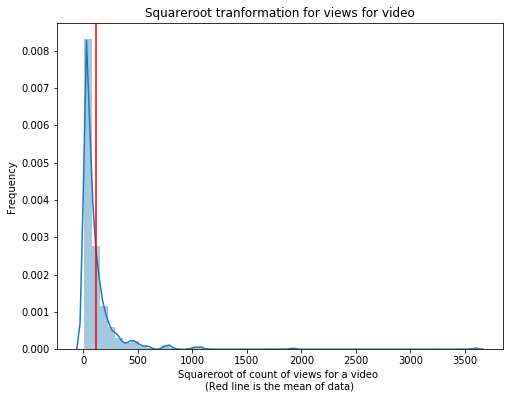

In [10]:
plt.figure(figsize = (8,6))
ax = sns.distplot([math.sqrt(x) for x in data['Views']])
plt.axvline(x=np.mean([math.sqrt(x) for x in data['Views']]), color='red')
ax.set(xlabel='Squareroot of count of views for a video \n(Red line is the mean of data)', 
       ylabel='Frequency', 
       title = 'Squareroot tranformation for views for video')
plt.show()

Since the distribution of data is near normal for the log transfornation, <b> we will use log transformation of the views.

### Outliers

In [11]:
"""
Function
--------
find_outlier_limits
    Returns the upper and lower limit beyond which datapoint is classified as outlier
    
Parameters
----------
data_col : Series data / data frame column which needs to be analysed


Returns
-------
R: lower_limit, upper_limit
    List with the lower and upper limits
"""

def find_outlier_limits(data_col):
    upper_quartile = np.percentile(data_col, 75)
    lower_quartile = np.percentile(data_col, 25)
    IQR = upper_quartile - lower_quartile   #interquartile range
    upper_limit = upper_quartile + IQR*1.5  # using the boxplot default of 1*5 times IQR
    lower_limit = lower_quartile - IQR*1.5
    return [lower_limit, upper_limit]

lower_limit, upper_limit = find_outlier_limits(np.log(data['Views']))

In [12]:
len(data[(np.log(data["Views"]) > upper_limit)])

2

We have only 2 datapoints that are outliers. As this is a small number of records (3% data), we drop these records.
#### Dropping outliers


In [13]:
outlier_rows = data[np.log(data["Views"]) > upper_limit].index
data.drop(outlier_rows, axis = 0, inplace= True)
data.shape

(617, 46)

### Feature Analysis

##### 1. Channel_name

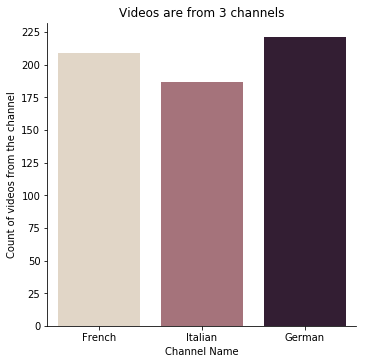

In [14]:
channel_name_dist = sns.catplot(x= 'channel_name' , kind="count", palette="ch:.25", data=data)
channel_name_dist.set(xlabel='Channel Name', 
                      ylabel='Count of videos from the channel', 
                      title = 'Videos are from 3 channels',
                      yticks = np.arange(0,250,25))
plt.show()

We have 3 channels - French Italian and German and the data is similarly divided between the 3 groups 

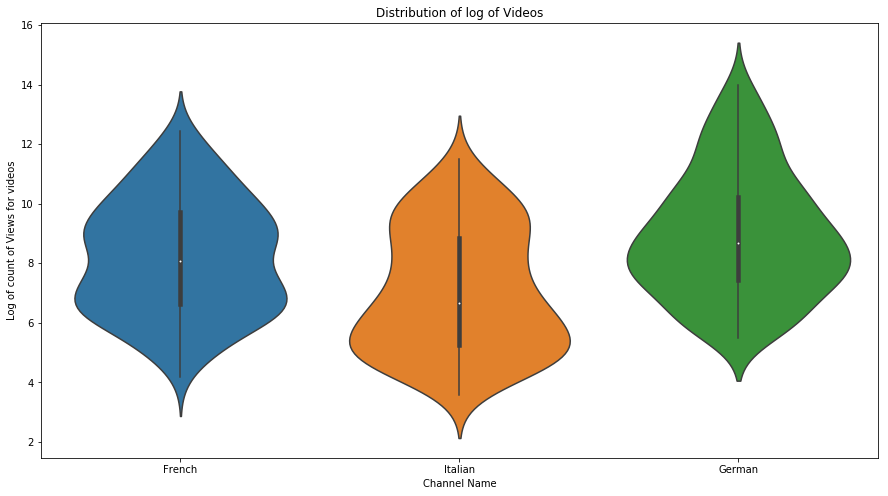

In [15]:
plt.figure(figsize = (15,8))
ax = sns.violinplot(x=data['channel_name'], y=np.log(data["Views"]))
ax.set(xlabel='Channel Name', 
      ylabel='Log of count of Views for videos', 
      title = 'Distribution of log of Videos')
plt.show()

Distribution for views across French and Italian videos is bimodal, while for German it is unimodal

##### 2. Length of video

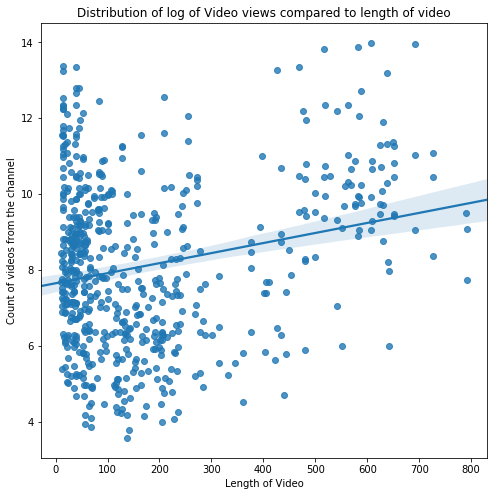

In [16]:
plt.figure(figsize = (8,8))
ax = sns.regplot(x=data['length'], y=np.log(data["Views"]))
ax.set(xlabel='Length of Video', 
      ylabel='Count of videos from the channel', 
      title = 'Distribution of log of Video views compared to length of video')
plt.show()

There is a slight trend of increase in the number of views for increasing length of video.

##### 3. Publish date

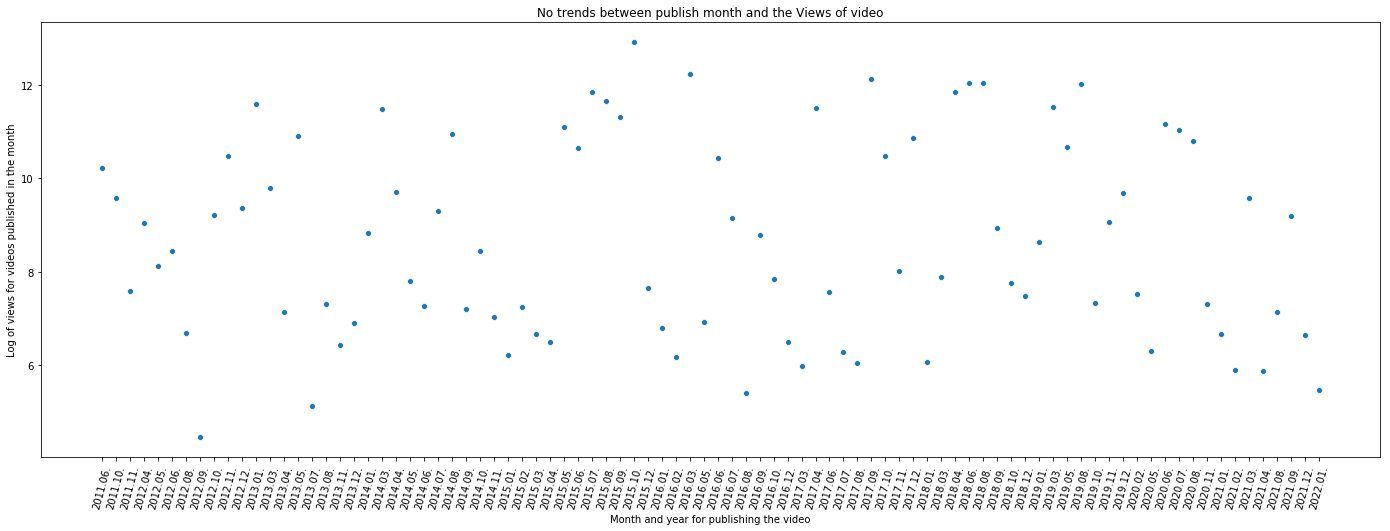

In [17]:
# Aggregating the data the level of a month
data['month_year'] = [x[:8] for x in data['publish_date']]
monthly_trend = data.groupby('month_year', as_index = False).mean()


# Plotting the data for log of views against published month
plt.figure(figsize = (24,8))
ax = sns.scatterplot(monthly_trend['month_year'], np.log(monthly_trend['Views']))
ax.set(xlabel='Month and year for publishing the video', 
       ylabel='Log of views for videos published in the month', 
       title = 'No trends between publish month and the Views of video')
plt.xticks(rotation=75)
plt.show()

There is no trend observed between the published month and the views

In [18]:
# Dropping the month year column
data.drop(columns='month_year', inplace= True, axis =1)

##### Correlation between the various recipe & genome features

In [19]:
"""
Function
--------
get_top_abs_correlations
    Returns the top n pairs with highest correlation
    
Parameters
----------
df: dataFrame where we want to analyse the correlations
n: Number of top pairs we wish to look at


Returns
-------
R: List with the correlated pair members and their coefficient of correlation 
"""


def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

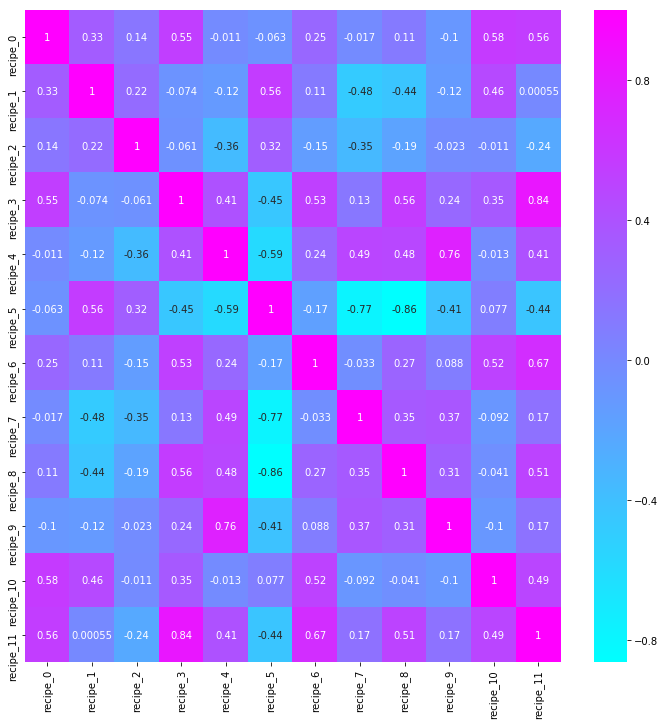

In [20]:
# Checking top correlated features among recipe

plt.figure(figsize = (12,12))
sns.heatmap(data.iloc[:,3:15].corr(), cmap = 'cool', annot = True)
plt.show()

In [21]:
# Print out the top correlated features among recipe

print( '\033[1m'  +  "Top Absolute Correlations among recipe features:\n" +  '\033[0m' )
print(get_top_abs_correlations(data.iloc[:,3:15], 10))

Top Absolute Correlations among recipe features:

recipe_5  recipe_8     0.861709
recipe_3  recipe_11    0.836030
recipe_5  recipe_7     0.774561
recipe_4  recipe_9     0.758661
recipe_6  recipe_11    0.668588
recipe_4  recipe_5     0.591707
recipe_0  recipe_10    0.577868
recipe_3  recipe_8     0.561412
recipe_1  recipe_5     0.557462
recipe_0  recipe_11    0.555206
dtype: float64


In [22]:
# Checking top correlated features among genome

print( '\033[1m'  +  "Top Absolute Correlations among genome features:\n" +  '\033[0m' )
print(get_top_abs_correlations(data.iloc[:,15:-1], 5))

Top Absolute Correlations among genome features:

genome_20  genome_25    0.997767
genome_3   genome_9     0.912068
genome_4   genome_29    0.902847
genome_0   genome_1     0.781922
genome_18  genome_22    0.447394
dtype: float64


##### Dropping the features that have correlation 
Dropping one of the 2 coulmns that have a correlation of >70%. We drop a total of 5 coulmns

In [23]:
data.drop(columns = ['genome_25','genome_9','genome_29', 'genome_1',
                     'recipe_8','recipe_11', 'recipe_7', 'recipe_9'], axis= 1, inplace= True)

## Data Prep

#### 1. Standardizing the data for better performance with models using Gradient descent

In [24]:
"""
Function
--------
standardize_df
    Returns the standardized form of the data

Parameters
----------
raw_data : DataFrame with the columns to be standardized


Returns
-------
R: DataFrame
    DataFrame with Standardized features
"""


def standardize_df(data):
    scalar = StandardScaler()
    standardized_data = scalar.fit_transform(data) #as table
    standardized_data = pd.DataFrame(data= standardized_data, index=data.index, columns = data.columns)
    return standardized_data

#### 2. Using one-hot encoding to handle the categorical variable channel_name

In [25]:
"""
Function
--------
data_encoding
    Returns dummy form for categorical variable

Parameters
----------
data : DataFrame with data that needs to be converted to dummies


Returns
-------
R: DataFrame
    DataFrame with given features converted to dummy form
"""

def data_encoding(data):
    data = pd.get_dummies(data['channel_name'], prefix='channel')
    return data

#### Preparing the data - normalizing and one-hot encoding

In [26]:
# Preparing data using the above functions
standardized_features = standardize_df(data.drop(columns=['Views','publish_date','channel_name'], axis=1))
encoded_data = data_encoding(data)

data = pd.concat([standardized_features,encoded_data, data[['Views', 'publish_date']]], axis = 1)

/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


#### 3. Train test split
Retaining videos with same publish date and same length together to avoid leakage from train to test

In [27]:
"""
Function
--------
TrainTestSplit
    Splits the data into train and test keeping videos of same length released on same channel grouped together
    
Parameters
----------
data : DataFrame that needs to be split into train and test
percent : Percentage of data to be assigned to train data


Returns
-------
train & test: DataFrame
    DataFrames divided into test and train data
"""

def TrainTestSplit(data, percent=0.80):
    
    # defining key columns using length and publish_date
    data["length-str"] = data["length"].apply(lambda x: str(x))
    data["video_unique_id"] = data["publish_date"] + data["length-str"] 
    unique_videos = set(data["video_unique_id"])
    
    # sampling required percentage of training keys
    random.seed(10)
    train_sample = random.sample(unique_videos, int(len(unique_videos)*percent))
    
    # filtering data using the training keys
    train = data[data.video_unique_id.isin(train_sample)]
    test = data[~data.video_unique_id.isin(train_sample)]
    print("train size: ", len(train), " test size: ", len(test))
    
    # dropping additional columns created by function
    train.drop(columns = ['length-str', 'video_unique_id'], axis = 1, inplace = True)
    test.drop(columns = ['length-str', 'video_unique_id'], axis = 1, inplace = True)
    
    return train, test

In [28]:
train_data, test_data = TrainTestSplit(data)

# generating X and Y for train data
X_train = train_data.drop(columns = ['publish_date', 'Views'], axis = 1)
y_train = np.log(train_data['Views'])

# generating X and Y for test data
X_test = test_data.drop(columns = ['publish_date', 'Views'], axis = 1)
y_test = np.log(test_data['Views'])

views_test = test_data['Views']

train size:  503  test size:  114


/Users/mugdhab/.local/lib/python3.7/site-packages/pandas/core/frame.py:3930: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


## Model building

#### 0. Baseline Model
Using the prediction of mean as the baseline model

In [29]:
y_pred = [y_test.mean() for x in range(len(y_test))]

print('Mean squared error is: %f  \nMean Absolute Error is: %f '%( mean_squared_error(y_test, y_pred),
                                                                        mean_absolute_error(y_test, y_pred)))


Mean squared error is: 3.572400  
Mean Absolute Error is: 1.607068 


/Users/mugdhab/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/mugdhab/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


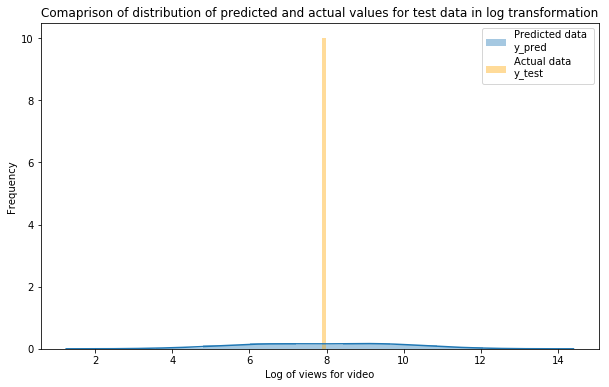

In [30]:
plt.figure(figsize = (10,6))
sns.distplot(y_test)
ax = sns.distplot(y_pred, color = 'orange')
ax.set(xlabel = ("Log of views for video"), 
       ylabel = ("Frequency"),
       title = 'Comaprison of distribution of predicted and actual values for test data in log transformation')
plt.legend(labels=["Predicted data \ny_pred","Actual data \ny_test"])
plt.show()

#### 1. Ridge regression

In [31]:
# Defining and fitting the model
clf = Ridge(alpha=0.1)
clf.fit(X_train, y_train)

# Generating predictions on test data and metrics
y_pred = clf.predict(X_test)
print('Co-efficient of determination R^2: %f \nMean squared error is: %f  \nMean Absolute Error is: %f '%(
                                                                        clf.score(X_test, y_test), 
                                                                        mean_squared_error(y_test, y_pred),
                                                                        mean_absolute_error(y_test, y_pred)))


Co-efficient of determination R^2: 0.118468 
Mean squared error is: 3.149186  
Mean Absolute Error is: 1.385658 


#### 2. MLPRegressor

In [32]:
# Defining and fitting the model
regr = MLPRegressor(hidden_layer_sizes=(100,), activation='relu',random_state=1, max_iter=10000)
regr.fit(X_train, y_train)

# Generating predictionson test data and metrics
y_pred = regr.predict(X_test)
print('Co-efficient of determination R^2: %f \nMean squared error is: %f  \nMean Absolute Error is: %f '%(
                                                                        regr.score(X_test, y_test), 
                                                                        mean_squared_error(y_test, y_pred),
                                                                        mean_absolute_error(y_test, y_pred)))

views_pred = np.exp(y_pred)

Co-efficient of determination R^2: -0.312180 
Mean squared error is: 4.687631  
Mean Absolute Error is: 1.595469 


#### 3. Gradient Booster Model

In [33]:
# Defining and fitting the model
reg = GradientBoostingRegressor(random_state=0, max_depth = 5)
reg.fit(X_train, y_train)

# Generating predictions on test data and metrics
y_pred = reg.predict(X_test)
print('Co-efficient of determination R^2: %f \nMean squared error is: %f  \nMean Absolute Error is: %f '%(
                                                                        reg.score(X_test, y_test), 
                                                                        mean_squared_error(y_test, y_pred),
                                                                        mean_absolute_error(y_test, y_pred)))

views_pred = np.exp(y_pred)

Co-efficient of determination R^2: 0.317721 
Mean squared error is: 2.437372  
Mean Absolute Error is: 1.200018 


#### Gradient Boosting gives us the best results with a MSE of ~2.4 to ~2.9
This model gives us a lift of 1.9 over the baseline model.

However this is MSE on log values. Let us look at the MSE on actual values

In [34]:
print('\nFor actual views without log: \n\tRoot mean squared error is: %f  \n\tMean Absolute Error is: %f '%(
                                                        math.sqrt(mean_squared_error(views_test, views_pred)),
                                                        mean_absolute_error(views_test, views_pred)))


For actual views without log: 
	Root mean squared error is: 51815.636951  
	Mean Absolute Error is: 13479.486079 


The MSE on actual values is very high. Lets us understand the model more.
### Analysis of the Gradient Boosting Model

<b> A. Visualizing the performance of model on test data (with log transform and in its original form

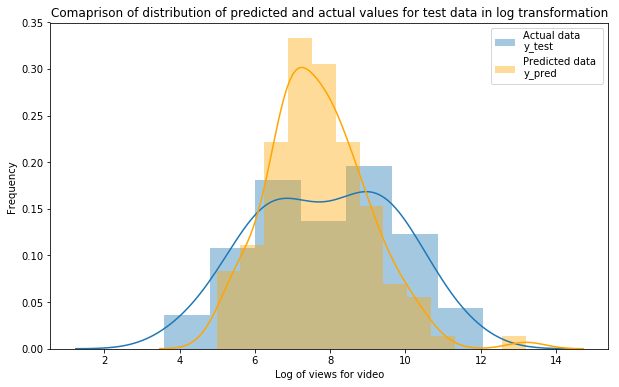

In [35]:
plt.figure(figsize = (10,6))
sns.distplot(y_test)
ax = sns.distplot(y_pred, color = 'orange')
ax.set(xlabel = ("Log of views for video"), 
       ylabel = ("Frequency"),
       title = 'Comaprison of distribution of predicted and actual values for test data in log transformation')
plt.legend(labels=["Actual data \ny_test", "Predicted data \ny_pred"])
plt.show()

###### Observation
Model prediction has lower variance and a higher peak than actual data. Model is predicting the values near the mean more often that that exists in actual data.

Let us also look at the actual values

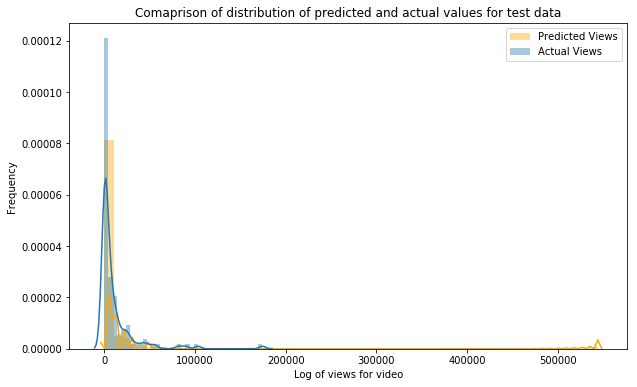

In [36]:
plt.figure(figsize = (10,6))
sns.distplot(views_pred, color = 'orange')
sns.distplot(views_test)
plt.xlabel('Log of views for video')
plt.ylabel("Frequency")
plt.title('Comaprison of distribution of predicted and actual values for test data')
plt.legend(labels=["Predicted Views","Actual Views"])
plt.show()

Let us quickly look at which features are most useful in this prediction.

<b> B. Feature Analysis

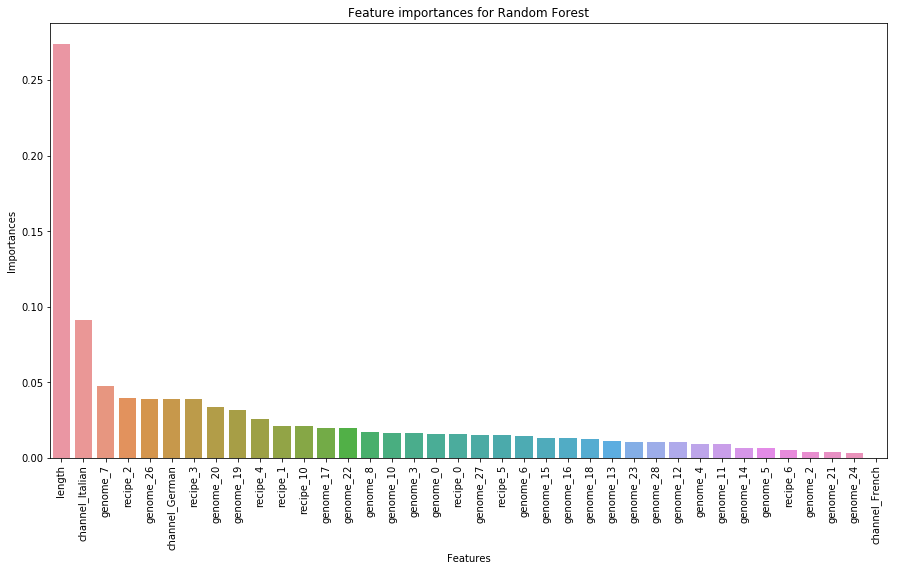

In [37]:
# Extracting the feature importance and sorting values by the importance level
feature_id = np.argsort(reg.feature_importances_)
features = [X_train.columns[i] for i in feature_id]
features.reverse()
importances = sorted(reg.feature_importances_)
importances.reverse()

# visualizing
plt.figure(figsize = (15,8))
sns.barplot(features, importances)
plt.xticks(rotation='vertical')
plt.title("Feature importances for Random Forest")
plt.xlabel("Features")
plt.ylabel("Importances")
plt.show()

As seen in the data the length of the video has the most feature importance followed by channel_name and genome_15

#### Post Regression Analysis
We can see the model perforance is not as optimal as we wish it to be. Let us revisit some assumptions for regression and also run some post-modelling checks.



<b><i> 1. Multicollinearity

In [38]:
np.linalg.cond(X_train)

5.651399455668304

The multicollinearity is high as we haven't dropped a few features with high correlation (values between 0.5 to 0.7).
<br /> We have retained these features as they may contain some valuable information for the prediction.

<b><i> 2. Actual vs predicted plot

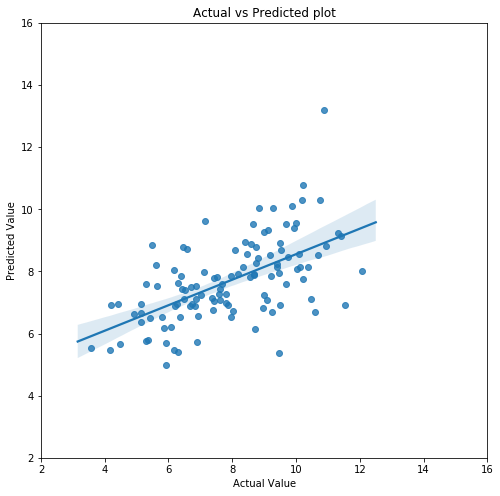

In [39]:
# generating the plot

plt.figure(figsize = (8,8))
ax = sns.regplot(y_test,y_pred)
ax.set(xlabel = ("Actual Value"), 
       ylabel = ("Predicted Value"),
       title = 'Actual vs Predicted plot',
      xlim = [2,16], ylim = [2,16])
plt.show()

As we can see from the MSE error this model is not the best fit for the data. There is weak correaltion between the actual and predicted data as the scatter points are not tightly bound near the line of fit and the slope of the line is farther from 1

<b><i> 3. Residual plot

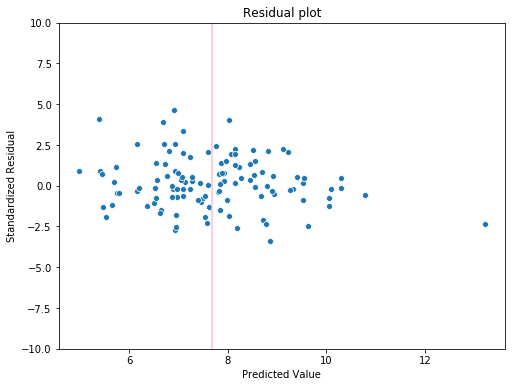

In [40]:
# Calculating the residuals and normalizing residuals
residual = y_test-y_pred

# Generating the residuals plot
plt.figure(figsize = (8,6))
ax = sns.scatterplot(x = y_pred, y = residual)
plt.axvline(x= y_pred.mean(), color='pink')
ax.set(xlabel = ("Predicted Value"), 
       ylabel = ("Standardized Residual"),
       title = 'Residual plot',
       ylim = [-10,10])
plt.show()

The residuals are well scattered across the predicted value. 

To confirm we use the <b> Breusch-Pagan Test to check for Heteroskedasticity.

In [41]:
name = ["Lagrange multiplier statistic", "p-value", "f-value", "f p-value"]
bp_test = sms.het_breuschpagan(residual, X_test)
lzip(name, bp_test)

[('Lagrange multiplier statistic', 40.96585689456105),
 ('p-value', 0.300682294249254),
 ('f-value', 1.1521472129903703),
 ('f p-value', 0.29672831426106716)]

We run the Breusch-Pagan Test to check for Heteroskedasticity. The significance level for the test is greater than 0.05. So we accept the null hypothesis that Homoskedasticity applies. There is no Heteroskedasticity.

<b><i> 4. Normality of residuals

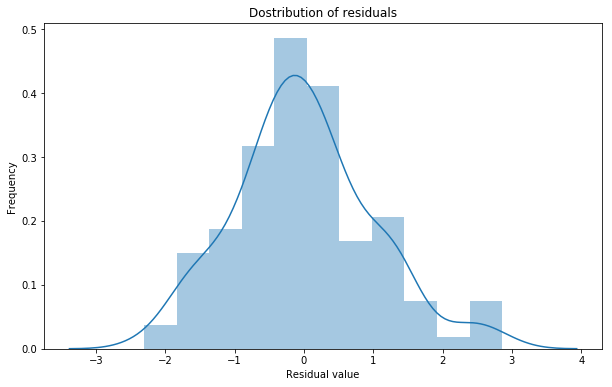

In [42]:
standardized_residual = (residual - np.mean(residual, axis = 0)) / np.std(residual, axis = 0)

plt.figure(figsize = (10,6))
ax = sns.distplot(standardized_residual)
ax.set(xlabel = ("Residual value"), 
       ylabel = ("Frequency"),
       title = 'Dostribution of residuals')
plt.show()

We use <b> Jarque-Bera Test to test for normality

In [43]:
name = ["Jarque-Bera", "Chi^2 two-tail prob.", "Skew", "Kurtosis"]
jb_test = sms.jarque_bera(residual)
lzip(name, jb_test)

[('Jarque-Bera', 2.480194975416555),
 ('Chi^2 two-tail prob.', 0.28935600790991994),
 ('Skew', 0.34821615494345537),
 ('Kurtosis', 3.1926871774654284)]

The significance value of test (p) is greater than 0.5. So we accept the Null hypothesis that <b> Data is normally distributed.

###### Posr-regression Analysis:
From the above analysis we can infer that our assumptions are satisfied and there are no trends that we need to be worried about.

Let us try some out-of-the-box apprach to see if a different model gives us better results

## Approach 2
Ensemble model with designed for this purpose with 3 stages - classification, regression and weighted sum
1. Classification - <br />
Divide data into 3 groups based on views for video. Predict the probability of each group
>A. unpopular ( Views < 1,000 )<br />
>B. average ( Views - 1,000 to 10,000 )<br />
C. popular ( Views > 10,000 )
2. Regression - <br />
Train a model for each group and predict the y for test from each group
> Train 3 models - 1 for each group.<br />
>Predict the number of views for test data according to each model
3. Weighted sum - <br />
> Take weighted sum of the probability for the class and the predicted value from regression model

### 1. Classification

In [44]:
# creating the 3 groups baed on views of video
train_data['views_category'] = ['popular' if x>10000 else ('average' if x>1000 else 'unpopular') 
                                for x in train_data['Views']]

test_data['views_category'] = ['popular' if x>10000 else ('average' if x>1000 else 'unpopular') 
                          for x in test_data['Views']]

/Users/mugdhab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/mugdhab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [45]:
# defining the X and Y for train data
X_train_class = train_data.drop(columns= ['Views','views_category', 'publish_date'], axis = 1)
y_train_class = train_data['views_category']

# defining the X and Y for test data
X_test_class = test_data.drop(columns= ['Views','views_category', 'publish_date'], axis = 1)
y_test_class = test_data['views_category']

#### 1. Decision tree -
Estimating the best parameter using Grid Search

In [46]:
# Defining and fitting the model
ds_tree = tree.DecisionTreeClassifier()
ds_tree.fit(X = X_train_class, y = y_train_class)

# Generating predictions on test data and metrics
y_pred_class = ds_tree.predict(X_test_class)

print("Accuracy: ", round(ds_tree.score(X = X_test_class, y = y_test_class)*100,2),"%")
print("Adjusted Rand Score: ", round(adjusted_rand_score(y_test_class, y_pred_class),4))

Accuracy:  49.12 %
Adjusted Rand Score:  0.0446


#### 2. Random Forest -
Estimating the best parameter using Grid Search

In [47]:
pca = decomposition.PCA()
rand_forest = RandomForestClassifier()
pipe = Pipeline(steps=[('pca', pca), ('rand_forest', rand_forest)])

n_components = list(range(1,X_train_class.shape[1]+1,1))
criterion = ['gini', 'entropy']
max_depth = [2,4,6,8,10,12]

parameters = dict(pca__n_components = n_components,
                      rand_forest__criterion = criterion,
                      rand_forest__max_depth = max_depth)

clf_GS = GridSearchCV(pipe, parameters)
clf_GS.fit(X = X_train_class, y = y_train_class)

/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", Futur

/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3

/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3

/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3

/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3

/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3

/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3

/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3

/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3

/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3

/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3

/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3

/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3

/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3

/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3

/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3

/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3

/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3

/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3

/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3

/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3

/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3

/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3

/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3

/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3

/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3

/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3

/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3

/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3

/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3

/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3

/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3

/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3

/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3

/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3

/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3

/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3

/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mugdhab/anaconda3/lib/python3

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('rand_forest', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
 ...obs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'pca__n_components': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38], 'rand_forest__criterion': ['gini', 'entropy'], 'rand_forest__max_depth': [2, 4, 6, 8, 10, 12]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [48]:
print('Best Criterion:', clf_GS.best_estimator_.get_params()['rand_forest__criterion'])
print('Best max_depth:', clf_GS.best_estimator_.get_params()['rand_forest__max_depth'])
print('Best Number Of Components:', clf_GS.best_estimator_.get_params()['pca__n_components'])
print(); print(clf_GS.best_estimator_.get_params()['rand_forest'])

Best Criterion: gini
Best max_depth: 10
Best Number Of Components: 23

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [49]:
# Defining and fitting the model
rand_forest = clf_GS.best_estimator_.get_params()['rand_forest']
rand_forest.fit(X = X_train_class, y = y_train_class)

# Generating predictions on test data and metrics
y_pred_class = rand_forest.predict(X_test_class)
y_pred_class_proba = rand_forest.predict_proba(X_test_class)

print("Accuracy: ", round(rand_forest.score(X = X_test_class, y = y_test_class)*100,2),"%")
print("Adjusted Rand Score: ", round(adjusted_rand_score(y_test_class, y_pred_class),4))

Accuracy:  67.54 %
Adjusted Rand Score:  0.2631


The Random Forest model with the best parameters gives us an accuracy of ~58%. We store the predictions for test data on all classes and continue with regression.

#### 2. Regression with each of the 3 groups

In [50]:
# Splitting the X for training data to respective category
X_train_1 = train_data[train_data['views_category']=='popular'].drop(columns= ['views_category','Views','publish_date'], axis = 1)
X_train_2 = train_data[train_data['views_category']=='average'].drop(columns= ['views_category','Views','publish_date'], axis = 1)
X_train_3 = train_data[train_data['views_category']=='unpopular'].drop(columns= ['views_category','Views','publish_date'], axis = 1)

# Splitting the dependent valriable of training data to respective category
y_train_1 = np.log(train_data[train_data['views_category']=='popular']['Views'])
y_train_2 = np.log(train_data[train_data['views_category']=='average']['Views'])
y_train_3 = np.log(train_data[train_data['views_category']=='unpopular']['Views'])

# preparing test data
X_test_regress = test_data.drop(columns= ['Views','views_category', 'publish_date'], axis = 1)
y_test_regress = np.log(test_data['Views'])


In [51]:
# fitting and predicting test values for popular videos
grad_boost_1 = GradientBoostingRegressor(random_state=0, max_depth = 5)
grad_boost_1.fit(X_train_1, y_train_1)
y_regress_pred_1 = grad_boost_1.predict(X_test_regress)
print("Model fitting for popular category videos is done.\n")

# fitting and predicting test values for average videos
grad_boost_2 = GradientBoostingRegressor(random_state=0, max_depth = 5)
grad_boost_2.fit(X_train_2, y_train_2)
y_regress_pred_2 = grad_boost_2.predict(X_test_regress)
print("Model fitting for average category videos is done.\n")

# fitting and predicting test values for average videos
grad_boost_3 = GradientBoostingRegressor(random_state=0, max_depth = 5)
grad_boost_3.fit(X_train_3, y_train_3)
y_regress_pred_3 = grad_boost_3.predict(X_test_regress)
print("Model fitting for unpopular category videos is done.")

Model fitting for popular category videos is done.

Model fitting for average category videos is done.

Model fitting for unpopular category videos is done.


#### 3. Weighted Sum

In [52]:
# creating an array with predictions from 3 regression models
y_pred_regress = np.array([y_regress_pred_1, y_regress_pred_2, y_regress_pred_3])

# taking matrix product for the probililty of belonging to a group and regressed values from each of the 3 models
y_pred_value = np.array([x[0] for x in y_pred_class_proba.dot(y_pred_regress)])

In [53]:
# calculating errors in log transformation

print('Mean squared error is: %f  \nMean Absolute Error is: %f '%(
    mean_squared_error(y_test_regress, y_pred_value), 
    mean_absolute_error(y_test_regress, y_pred_value)))

Mean squared error is: 3.101560  
Mean Absolute Error is: 1.452514 


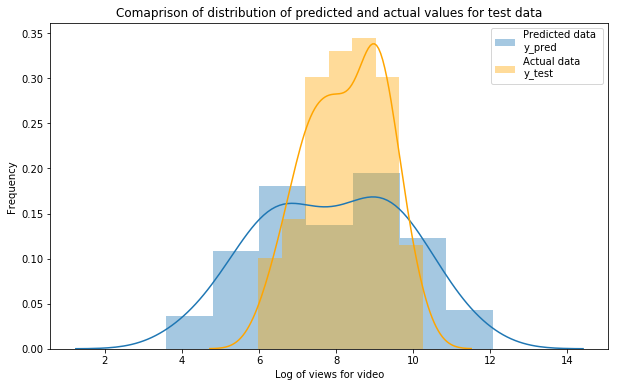

In [54]:
plt.figure(figsize = (10,6))
sns.distplot(y_test_regress)
ax = sns.distplot(y_pred_value, color = 'orange')
ax.set(xlabel = ("Log of views for video"), 
       ylabel = ("Frequency"),
       title = 'Comaprison of distribution of predicted and actual values for test data')
plt.legend(labels=["Predicted data \ny_pred","Actual data \ny_test"])
plt.show()

As we see our approach 2 does not give us better model than Gradient Booster model.
> - For approach 2 the variance of predicted data reduces further and the peak at the mean is higher.<br />
> - It is better to use the gradient boosting model

<h4 align="center"> ---------- Thank You! ---------------- </h3> 